In [8]:
import numpy as np
import scipy as sp
import scipy.integrate as spi
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import torch

In [9]:
class Sigma:
    """
    Class for the custom sigma function used on the degree vector.
    """
    def __init__(self, fn, image):
        self.fn = fn # take a torch tensor and return a torch tensor
        self.image = image
    
    def __call__(self, x):
        if isinstance(x, torch.Tensor):
            return self.fn(x)
        elif isinstance(x, np.ndarray):
            return self.fn(torch.from_numpy(x)).numpy()
        elif isinstance(x, float):
            return self.fn(torch.tensor([x])).item()

def solve_equation(f, a, b, tol=1e-5, max_iter=1000):
    """
    Find the root of the function f in the interval [a, b] using binary search.
    """
    for _ in range(max_iter):
        midpoint = (a + b) / 2.0
        if abs(f(midpoint)) < tol:
            return midpoint
        elif f(a) * f(midpoint) < 0:
            b = midpoint
        else:
            a = midpoint
    raise ValueError("Maximum number of iterations reached.")


def gaussian_integral(f):
    """General calculation of E[f(x)] for x ~ N(0, 1)."""
    return spi.quad(
        lambda x: f(x) * np.exp(-x ** 2 / 2.0) / np.sqrt(2.0 * np.pi), 
        -np.inf, np.inf)[0]

def H(z, sigma):
    """Subordination function."""
    return z + gaussian_integral(lambda x: 1 / (z - sigma(x)))

def H_prime(z, sigma):
    """Subordination function derivative."""
    if z > sigma.image[0] and z < sigma.image[1]: # H_prime undefined when z is in the range of the support of nu
        return -np.inf
    return 1.0 - gaussian_integral(lambda x: 1 / (z - sigma(x)) ** 2)

def theta(c, sigma):
    """Compute the effective signal."""
    def f(lam): # lam_max is the root of this function, note it decreases in lam
        return gaussian_integral(lambda x: 1.0 / (lam - sigma(c + x))) - 1.0 / c
    
    a = sigma.image[1] + 1e-7 # lower bound for lam_max
    b = c + max(abs(sigma.image[0]), abs(sigma.image[1])) # upper bound for lam_max
    
    if not (f(a)>0 and f(b)<0): # no outlier eigenvalue (outside the image of sigma)
        return sigma.image[1]

    # find a coarse estimate for lam_max
    xs = np.linspace(a, b, 100)
    f_values = np.array([f(lam) for lam in xs])
    # plt.plot(xs, f_values)
    # plt.show()
    i = np.where(f_values > 0)[0][-1]

    # get a more accurate estimate for lam_max
    lam_max = solve_equation(f, xs[i], xs[i+1]) # find the root by binary search
    return lam_max

def c_critical(c_values, sigma):
    """Critical value of c."""
    # plot the diagram for H_prime values, and get a coarse estimate for c_critical
    theta_values = np.array([theta(c,sigma) for c in c_values])
    H_prime_values = np.array([H_prime(theta, sigma) for theta in theta_values])
    i = np.where(H_prime_values > -1)[0][0] # only plot the part where H_prime > -1
    fig, axes = plt.subplots(2, 1, sharex=True)
    axes[0].plot(c_values[i:], theta_values[i:])
    axes[1].plot(c_values[i:], H_prime_values[i:])  
    axes[0].set_xlabel('$c$ (clique size)')
    axes[0].set_ylabel('$\\theta(c)$ (effective signal)')  
    axes[1].set_xlabel('$c$ (clique size)')
    axes[1].set_ylabel('$H^{\\prime}(\\theta(c))$')
    plt.show()

    # get a more accurate estimate for c_critical
    c_est_inx = np.where(H_prime_values > 0)[0][0]
    c_critical = solve_equation(lambda c: H_prime(theta(c, sigma),sigma), c_values[c_est_inx-1], c_values[c_est_inx])
    return c_critical

def outlier_eval(c, sigma):
    """Evaluate the outlier eigenvalue when c > c_critical."""
    return H(theta(c, sigma), sigma)


# Validation of the method on simple $\sigma = \tanh$ 

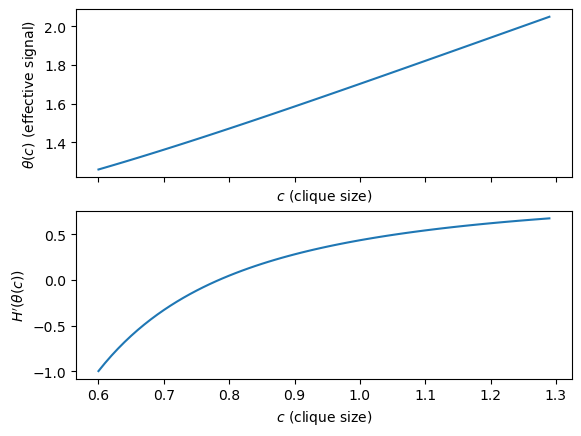

0.7843457031250003

In [3]:
sigma = Sigma(lambda x:torch.tanh(x), [-1,1])
c_critical(np.arange(0.5, 1.3, 1e-2), sigma)

In [10]:
def _plant_clique(G, k):
    n = G.number_of_nodes()
    vertices = np.random.choice(np.arange(n), k, replace=False)
    for index, u in enumerate(vertices):
        for v in vertices[index + 1 :]:
            G.add_edge(u, v)
    return G

def custom_laplacian_lam_max(A, sigma):
    """Given adjacency matrix A, compute lambda_max(L) where L = \hat{A} + diag(sigma(\hat{d}))"""
    A = torch.Tensor(A).squeeze()
    n = A.shape[-1]
    A_normalized = (A * 2 - torch.ones(n,n) + torch.eye(n))/ np.sqrt(n)
    D = sigma(A_normalized.sum(axis=1))
    evals = torch.linalg.eigvalsh(A_normalized + torch.diag_embed(D))
    return evals.max().item()

def find_lam_max(sigma, n_range=np.arange(2000, 3000,500), c=0.8, num_trials = 50):
    er = {}
    planted = {}
    for n in tqdm(n_range):
        k = int(c*np.sqrt(n))
        er_n = []
        planted_n = []
        for trials in tqdm(range(num_trials)):
            # generate a random ER graph
            G = nx.erdos_renyi_graph(n, p=.5)
            A = nx.adjacency_matrix(G).toarray()
            er_n.append(custom_laplacian_lam_max(A, sigma))
            # generate a random planted graph
            G = nx.erdos_renyi_graph(n, p=.5)
            G = _plant_clique(G, k)
            A = nx.adjacency_matrix(G).toarray()    
            planted_n.append(custom_laplacian_lam_max(A, sigma))
        er[n] = er_n
        planted[n] = planted_n
    return er, planted


def find_lam_max(sigma, n, c, num_trials=100):
    er = {}
    planted = {}
    k = int(c * np.sqrt(n))
    er_n = []
    planted_n = []
    for trials in tqdm(range(num_trials)):
        # generate a random ER graph
        G = nx.erdos_renyi_graph(n, p=0.5)
        A = nx.adjacency_matrix(G).toarray()
        er_n.append(custom_laplacian_lam_max(A, sigma))
        # generate a random planted graph
        G = nx.erdos_renyi_graph(n, p=0.5)
        G = _plant_clique(G, k)
        A = nx.adjacency_matrix(G).toarray()
        planted_n.append(custom_laplacian_lam_max(A, sigma))
    er[n] = er_n
    planted[n] = planted_n
    return er, planted


def layer_plot(
        ax,
        xs,
        yss,
        max_points=None,
        label=None,
        only_means=False,
        errorbars=False,
        color=None,
        sigma=1.0,
        fill_alpha=0.3,
        linestyle='-',
        linewidth=1,
        elinewidth=1):
    means = np.array([np.mean(ys) for ys in yss])
    devs = np.array([np.std(ys) * sigma for ys in yss])
    print(means)
    if max_points is not None:
        n = xs.shape[0]
        thin = max(1, n // max_points)
        xs = xs[::thin]
        means = means[::thin]
        devs = devs[::thin]
    if errorbars:
        ax.scatter(xs, means, c=color, label=label)
        ax.errorbar(xs, means, yerr=devs, linestyle=linestyle, linewidth=linewidth, elinewidth=elinewidth, c=color)
    else:
        ax.plot(xs, means, c=color, label=label, linestyle=linestyle, linewidth=linewidth)
        if not only_means:
            ax.fill_between(xs, means, means + devs, alpha=fill_alpha, color=color)
            ax.fill_between(xs, means, means - devs, alpha=fill_alpha, color=color)

def plot_lam_max(er, planted, n_range):
    er = [er[n] for n in n_range]
    planted = [planted[n] for n in n_range]
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    layer_plot(ax, n_range, er, label='ER', errorbars=False, color = "blue")
    layer_plot(ax, n_range, planted, label='Planted', errorbars=False, color = "orange")
    ax.set_xlabel('n')
    ax.set_ylabel('Maximum Eigenvalue')
    ax.legend()
    plt.show()

In [5]:
# c=0.8
outlier_eval(0.8, sigma)

/tmp/ipykernel_2614584/3198752794.py:34: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return spi.quad(
/tmp/ipykernel_2614584/3198752794.py:34: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return spi.quad(


2.3313929033428753

In [8]:
er, planted = find_lam_max(sigma, n_range=np.arange(2000, 3500,500), c=0.8)

100%|██████████| 3/3 [25:54<00:00, 518.01s/it]


[2.3189535 2.3237648 2.3253834]
[2.3374226 2.3370156 2.3367243]


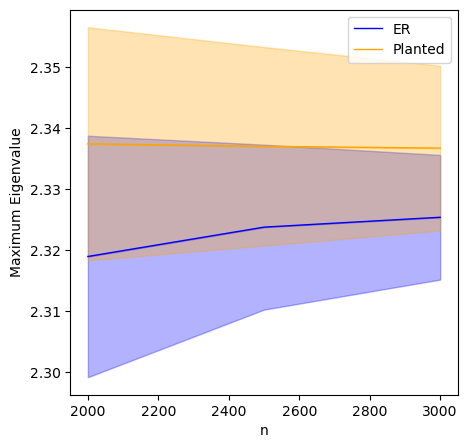

In [10]:
plot_lam_max(er, planted, np.arange(2000, 3500,500))

In [11]:
# c=1
outlier_eval(1.0, sigma)

/tmp/ipykernel_2614584/3198752794.py:34: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return spi.quad(
/tmp/ipykernel_2614584/3198752794.py:34: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return spi.quad(


2.3936026712285337

100%|██████████| 3/3 [26:12<00:00, 524.23s/it]

[2.320394  2.328399  2.3249865]
[2.3778467 2.385728  2.3821602]


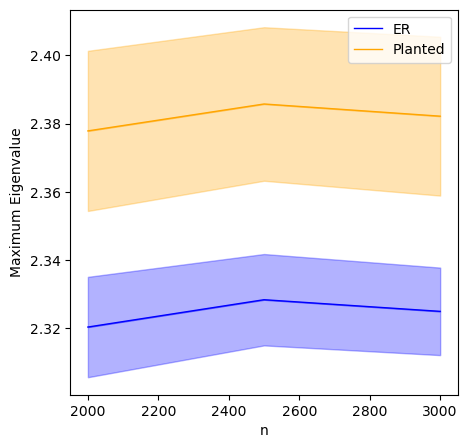

In [12]:
er, planted = find_lam_max(sigma, n_range=np.arange(2000, 3500, 500), c=1)
plot_lam_max(er, planted, np.arange(2000, 3500, 500))

# Validation of the method on learned model

In [11]:
import wandb
import shutil,os
import pytorch_lightning as pl
import torch.nn as nn
import torch
from train import GNNTrainingModule

CURRENT_DIR = os.getcwd()
ENTITY_NAME = "yuxinma"
PROJECT_NAME = "planted_clique_v2"

ptwise_degree_model = ["m2e9wwl6", "ng6lo20c", "ifugj2bs", "c706gw3o", "b8nvdxoc"]
ptwise_degree_model2 = ["lghepjzi", "x03ktnj8", "wgn96mpy", "okvs07ur"]

def download_best_model(run_id: str) -> pl.LightningModule:
    """ Download from wandb logs the model checkpoint and its config"""
    #download the best model checkpoint
    api = wandb.Api()
    artifact = api.artifact(f"{ENTITY_NAME}/{PROJECT_NAME}/model-{run_id}:best")  #download the best_model
    best_ckpt = artifact.download(root = os.path.join(CURRENT_DIR, "downloaded_artifact"))
    best_ckpt = os.path.join(best_ckpt, "model.ckpt")
    best_model = GNNTrainingModule.load_from_checkpoint(best_ckpt, map_location=None)

    #get the run config
    run = api.run(f"{ENTITY_NAME}/{PROJECT_NAME}/{run_id}")
    config = run.config

    #clean up
    shutil.rmtree(os.path.dirname(best_ckpt))
    return best_model, config

def asymptotic_analysis(model,n,c):
    """Plot histogram of eigenvalues of X and L for a planted clique graph.
    """
    model.eval()
    model.to('cpu')
    k = int(c*np.sqrt(n))
    G = nx.erdos_renyi_graph(n, p=.5)
    A0 = nx.adjacency_matrix(G).toarray()
    A0 = torch.Tensor(A0).unsqueeze(0)
    A0 = (A0 * 2 - torch.ones(n, n) + torch.eye(n)) / np.sqrt(n)
        
    G = _plant_clique(G, k)
    A = nx.adjacency_matrix(G).toarray()
    A = torch.Tensor(A).unsqueeze(0)
    A, x, pred = model(A)
    A = A.squeeze(0).squeeze(0)
    
    X = A- A0
    D = torch.linalg.eigvalsh(X).squeeze().detach().numpy()
    plt.figure(figsize=(10, 5))
    plt.hist(D, bins=200)
    plt.title(r"Eigenvalue Histogram of $X=c\hat 1_S \hat 1_S^{\top} + diag(\sigma(c1_S + d))$")
    plt.show()

    D = torch.linalg.eigvalsh(A).squeeze().detach().numpy()
    print(D.max())
    plt.figure(figsize=(10, 5))
    plt.hist(D, bins=200)
    plt.title(r"Eigenvalue Histogram of $L = \frac{W}{\sqrt{n}} + X$")
    plt.show()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb:   1 of 1 files downloaded.  


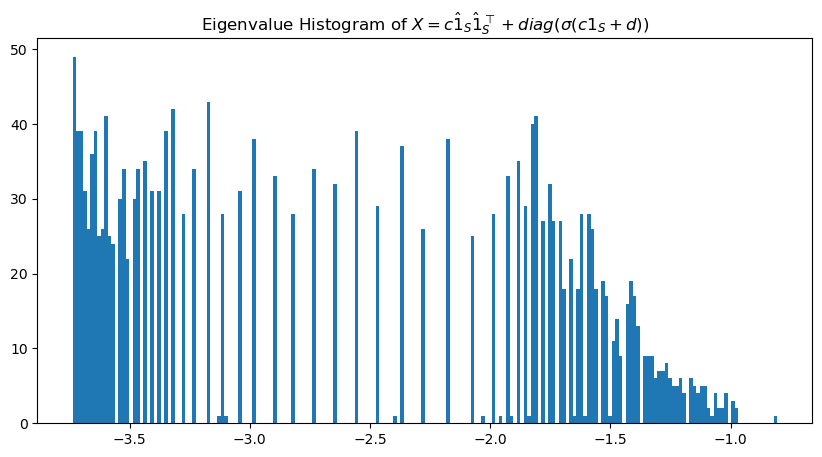

0.0132721765


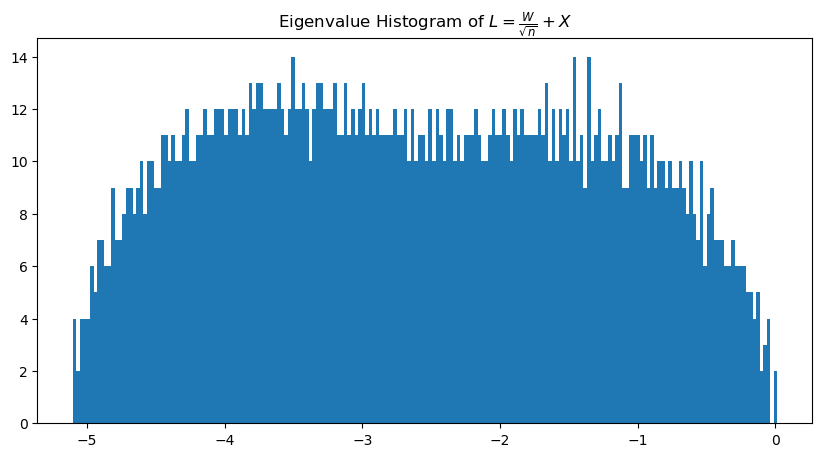

In [13]:
model,config = download_best_model(ptwise_degree_model[0])
asymptotic_analysis(model,2000,.8)

/tmp/ipykernel_2614584/1009986017.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  x = torch.range(-10, 10, 0.1).unsqueeze(1)


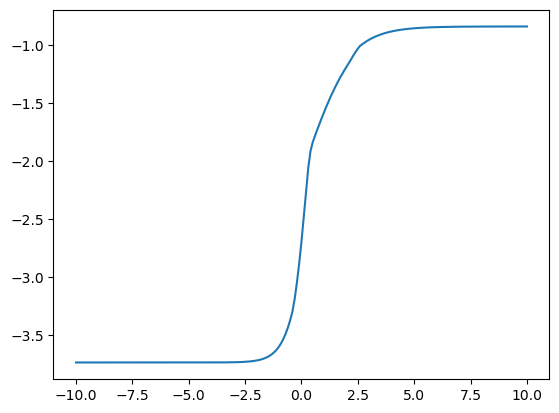

In [15]:
x = torch.range(-10, 10, 0.1).unsqueeze(1)
y = model.model.mlp1(x)
y = nn.Tanh()(y)
y = model.model.mlp2(y) 
plt.plot(x.detach().cpu().numpy(), y.detach().cpu().numpy())


In [14]:
def learned_model(x):
    if x.dim() == 0:
        x = x.reshape(1,1).float()
    if x.dim() == 1:
        x = x.reshape(-1,1).float()
    y = model.model.mlp1(x)
    y = nn.Tanh()(y)
    y = model.model.mlp2(y)
    y = y.squeeze()
    return y

test_xs = torch.linspace(-100, 100, 1000)
image = [learned_model(test_xs).min().item(), learned_model(test_xs).max().item()]
print(image)
sigma = Sigma(learned_model, image)

[-3.73762583732605, -0.8382097482681274]


/tmp/ipykernel_2614584/3198752794.py:34: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return spi.quad(
/tmp/ipykernel_2614584/3198752794.py:34: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return spi.quad(


/tmp/ipykernel_2614584/3198752794.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  return 1.0 - gaussian_integral(lambda x: 1 / (z - sigma(x)) ** 2)
/tmp/ipykernel_2614584/3198752794.py:35: RuntimeWarning: invalid value encountered in double_scalars
  lambda x: f(x) * np.exp(-x ** 2 / 2.0) / np.sqrt(2.0 * np.pi),


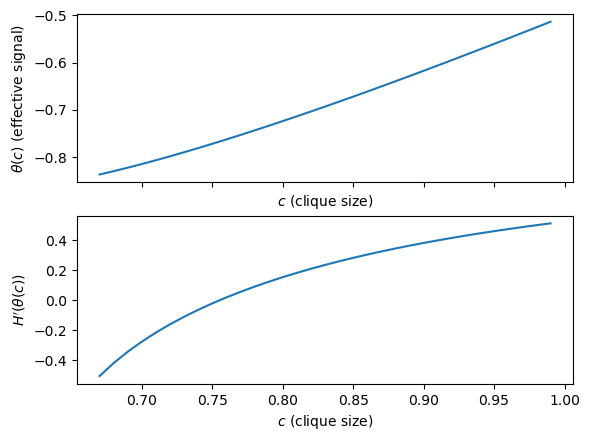

c_critical for m2e9wwl6 = 0.7553027343750001


In [17]:
print(f"c_critical for {ptwise_degree_model[0]} = {c_critical(np.arange(0.6, 1.0, 1e-2), sigma)}")

In [15]:
outlier_eval(0.75, sigma)

/tmp/ipykernel_2651913/3198752794.py:34: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return spi.quad(
/tmp/ipykernel_2651913/3198752794.py:34: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return spi.quad(


0.017885148446702637

In [18]:
# c=0.8
outlier_eval(0.8, sigma)

/tmp/ipykernel_2614584/3198752794.py:34: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return spi.quad(
/tmp/ipykernel_2614584/3198752794.py:34: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return spi.quad(


0.0213268047502978

In [20]:
er, planted = find_lam_max(sigma, n_range=np.arange(2000, 3500, 500), c=0.8, num_trials=100)

100%|██████████| 3/3 [49:13<00:00, 984.60s/it] 


[0.01312651 0.01651728 0.01949613]
[0.03263712 0.03529229 0.03509303]


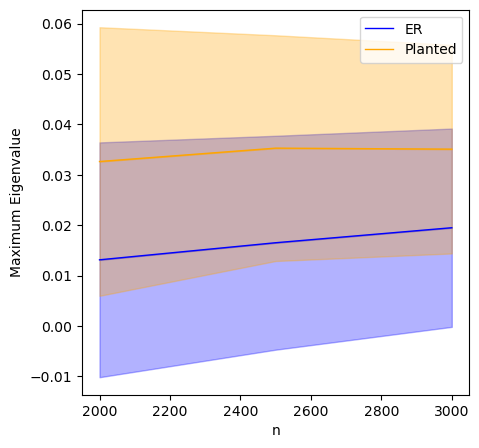

In [21]:
plot_lam_max(er, planted, np.arange(2000, 3500, 500))

In [16]:
outlier_eval(2, sigma)

/tmp/ipykernel_2651913/3198752794.py:34: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return spi.quad(
/tmp/ipykernel_2651913/3198752794.py:34: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return spi.quad(


1.0957327934558707

In [17]:
er, planted = find_lam_max(sigma, n_range=np.arange(2000, 3500, 500), c=2, num_trials=100)

100%|██████████| 3/3 [50:28<00:00, 1009.51s/it]


[0.01697059 0.01627697 0.01600619]
[1.05577498 1.07123472 1.05623381]


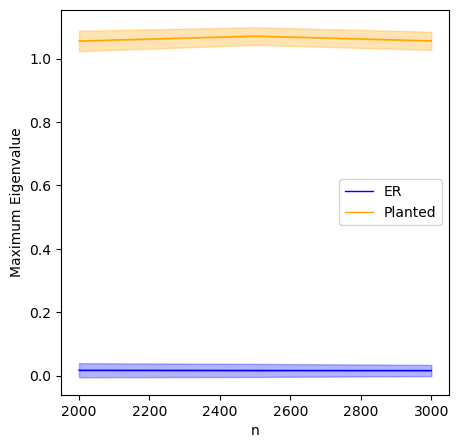

In [19]:
plot_lam_max(er, planted, np.arange(2000, 3500, 500))

In [22]:
outlier_eval(5, sigma)

/tmp/ipykernel_2651913/3198752794.py:34: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return spi.quad(
/tmp/ipykernel_2651913/3198752794.py:34: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return spi.quad(


4.2875760287929285

In [23]:
er, planted = find_lam_max(sigma, n_range=np.arange(2000, 3500, 500), c=5, num_trials=100)

100%|██████████| 3/3 [49:23<00:00, 987.96s/it] 


[0.01664153 0.01497738 0.02036876]
[4.23594371 4.25433989 4.24211484]


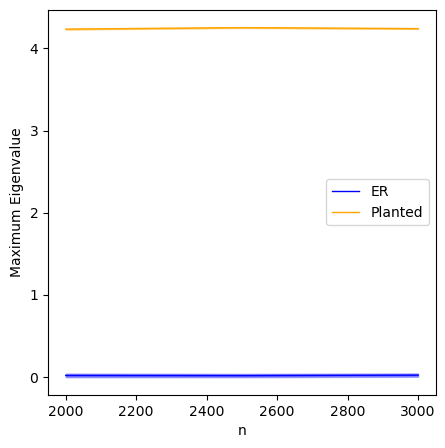

In [24]:
plot_lam_max(er, planted, np.arange(2000, 3500, 500))